In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import matplotlib.colors as mcol
import matplotlib.cm as cm
import pickle
import os
import imageio
import gc
import cv2
from scipy import stats
from scipy import ndimage #for finding com
from scipy.misc import imsave
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [2]:
experiment=input("Regarding experiment date and number (six digit id): Enter YYMMDD_######   -")

Regarding experiment date and number (six digit id): Enter YYMMDD_######   -180731_000001


In [3]:
os.chdir(experiment)
os.mkdir(experiment+'_depth_frames')
os.mkdir(experiment+'_color_frames')

In [4]:
with open(experiment+'_variables', 'rb') as variables:
    number_of_frames,frame_height,frame_width,fps,background_chunk = pickle.load(variables)
    
exp_numb=0
box_size=192
stringency=10
grand_frame=int(exp_numb*(number_of_frames-background_chunk))
min_range=0
max_range=800 #1000

In [5]:
depthfilename='%s_raw_depth.gz'%experiment
colorfilename='%s_raw_color.gz'%experiment

In [6]:
#Load and uncompress data
input_file = gzip.GzipFile(depthfilename, 'rb')
data = input_file.read()
input_file.close()

output_file = open("depthdata.bin", 'wb')
output_file.write(data)
output_file.close()

In [7]:
background_frames = np.fromfile('depthdata.bin', dtype=np.uint16, count=(int(frame_height*frame_width*background_chunk*16))).reshape(-1, frame_height, frame_width)[0:background_chunk]

backgroundmean=np.mean(background_frames, axis=0) #may be better to use median
backgroundvariance=np.var(background_frames, axis=0)

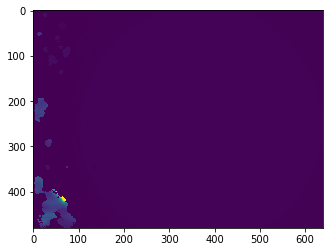

In [8]:
plt.imshow(background_frames[6])

In [9]:
current_frame=0
frames = np.fromfile('depthdata.bin', dtype=np.uint16).reshape(-1, frame_height, frame_width)[background_chunk:number_of_frames]
for f in range(int(number_of_frames-background_chunk)):
        
    #FRAME TO PROCESS
    frame_of_interest=frames[current_frame] 
        
    #IF PIXEL ISN'T SIGNIFICANTLY DIFFERENT FROM THE BACKGROUND THEN DROP IT
    backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (stringency*np.sqrt(backgroundvariance)) 

    #WE EXPECT POSITIVE VALUES FOR HIGH DIFFERENCES make them stay by multiplying by 1
    backgroundmultiplier[backgroundmultiplier>0]=1
    #WE EXPECT NEGATIVE VALUES FOR SMALL OR NO DIFFERENCE probably just noise, get rid of them by multiplying by 0
    backgroundmultiplier[backgroundmultiplier<=0]=0
       
    # SUBTRACT BACKGROUND BY MULTIPLYING INSIGNIFIACNT FRAMES BY ZERO
    frame_of_interest_backgroundsubtracted=(np.multiply(frame_of_interest,backgroundmultiplier)).astype('uint8') #IMWRITE TAKES UINT8
    frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>max_range]=0
    frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<=min_range]=0
        
    #################################################################
    #ALGORITHIM FOR FINDING THE CENTER OF THE OBJECT (TO CROP THE PLOT) (this actually works better than any built in function I've tried)
    #basically, the row and column with the most non zero values should be the center
        
    winningrow=0
    winningcountr=frame_width
    for rowpixels in range(0,frame_height):
        currentcountr=np.count_nonzero(frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
        if currentcountr<winningcountr:
            winningcountr=currentcountr
            winningrow=rowpixels

    winningcolumn=0
    winningcountc=frame_height
    for columnpixels in range(0,frame_width):
        currentcountc=np.count_nonzero(frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
        if currentcountc<winningcountc:
            winningcountc=currentcountc
            winningcolumn=columnpixels

    if winningrow<(box_size/2):
        winningrow=(int(box_size/2))
    if winningrow>(frame_height-box_size/2):
        winningrow=int(frame_height-box_size/2-1)
    if winningcolumn<(box_size/2):
        winningcolumn=(int(box_size/2))
    if winningcolumn>(frame_width-box_size/2):
        winningcolumn=int(frame_width-box_size/2-1)
        
        ####################################################################

        #THIS IS THE FRAME NUMBER (I WILL COMBINE MANY RUNS SO I'M OUTPUTTING THE MASTER FRAME NUMBER)
    fplusd=int(f+grand_frame)
    print(fplusd)
       

        # THIS IS HOW I SHOULD SAVE ARRAYS SO THEY COME OUT AS 192 by 192 FOR IMAGE ANALYSIS (IT'S SMALLER!)
    imageio.imwrite(experiment + '_depth_frames/depth_frame_%06d.png' %(fplusd),frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2)])

    current_frame=current_frame+1
        
        
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899


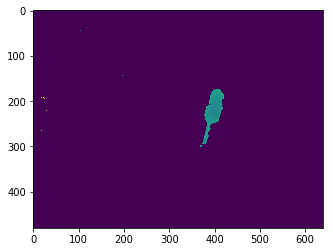

In [10]:
plt.imshow(frame_of_interest_backgroundsubtracted)